In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display
import os
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
import pickle
import math
import random
import sklearn

In [3]:
block_duration = 0.5
window = 'hann'
features = []
labels = []

In [4]:
feature_list = []
label_list = []
loc_pos = '../optimized'
for file in tqdm(os.listdir(loc_pos)):
    # Skip if it's not a mp3 file
    if not file.endswith('.mp3'):
        continue
    # Load audio and stretch it to length 1s
    audio_path = os.path.join(loc_pos, file)
    # audio, sr = librosa.load(path=audio_path, sr=None)
    # audio = librosa.effects.time_stretch(y=audio, rate=len(audio)/sr)
    # Calculate features and get the label from the filename
    audio,sr = librosa.load(audio_path,sr=44100)
    buffer = int(block_duration * sr)

    samples_total = len(audio)
    # print(samples_total)
    samples_wrote = 0
    j= 0
    while samples_wrote < samples_total:
        #check if the buffer is not exceeding total samples 
        if buffer > (samples_total - samples_wrote):
            break
        y_block = audio[samples_wrote : (samples_wrote + buffer)]
        
        mels = librosa.feature.melspectrogram(y=y_block,
                                                sr=sr,
                                                n_fft=512,
                                                hop_length=512,
                                                center=False,
                                                window=window)
        mels_db = librosa.power_to_db(mels, ref=1.0)
        feature_list.append(mels_db.reshape((128, int(math.floor(21.5*block_duration*4)), 1)))
        label_list.append('1')
        samples_wrote += int(buffer/18)
        j+=1
features+=feature_list
labels+=label_list


In [7]:
feature_list = []
label_list = []
loc_neg = '../speech'
for file in tqdm(os.listdir(loc_neg)):
    # Skip if it's not a mp3 file
    if not file.endswith('.mp3'):
        continue
    audio_path = os.path.join(loc_neg, file)
    
    # Calculate features and get the label from the filename
    audio,sr = librosa.load(audio_path,sr=44100)
    buffer = int(block_duration * sr)

    samples_total = len(audio)
    samples_wrote = 0
    j= 0
    while samples_wrote < samples_total:
        if buffer > (samples_total - samples_wrote):
            break
        y_block = audio[samples_wrote : (samples_wrote + buffer)]
        #check if the buffer is not exceeding total samples 
        mels = librosa.feature.melspectrogram(y=y_block,
                                                sr=sr,
                                                n_fft=512,
                                                hop_length=512,
                                                center=False,
                                                window=window)
        mels_db = librosa.power_to_db(mels, ref=1.0)
        feature_list.append(mels_db.reshape((128, int(math.floor(21.5*block_duration*4)), 1)))
        label_list.append('0')
        samples_wrote += int(buffer/2)
        j+=1
features+=feature_list
labels+=label_list

100%|██████████| 4470/4470 [06:06<00:00, 12.21it/s]


239416
239416


In [9]:
features=np.array(features)
labels=np.array(labels)

239416

In [12]:
model = tf.keras.models.Sequential([
    #first_convolution
    keras.layers.InputLayer(input_shape=features[0].shape),
    keras.layers.Conv2D(16, 3, padding='same', activation=keras.activations.relu),
    keras.layers.MaxPooling2D(),
    #second_convolution
    keras.layers.Conv2D(32, 3, padding='same', activation=keras.activations.relu),
    keras.layers.MaxPooling2D(),
    #third_convolution
    keras.layers.Conv2D(64, 3, padding='same', activation=keras.activations.relu),
    keras.layers.MaxPooling2D(),
    #fourth_convolution
    keras.layers.Conv2D(128, 3, padding='same', activation=keras.activations.relu),
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    # keras.layers.Dropout(0.3),
    keras.layers.Dense(1024, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(2, activation='softmax') 
]) 
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 43, 16)    │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 21, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 5, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 5, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 8, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,721,154 (10.38 MB)

 Trainable params: 2,721,154 (10.38 MB)

 Non-trainable params: 0 (0.00 B)

None


Epoch 1/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 310s 25ms/step - accuracy: 0.7731 - loss: 0.4900 - val_accuracy: 0.8403 - val_loss: 0.3628
Epoch 2/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 275s 23ms/step - accuracy: 0.8456 - loss: 0.3531 - val_accuracy: 0.8668 - val_loss: 0.3115
Epoch 3/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 280s 24ms/step - accuracy: 0.8844 - loss: 0.2742 - val_accuracy: 0.8873 - val_loss: 0.2702
Epoch 4/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 277s 24ms/step - accuracy: 0.9145 - loss: 0.2078 - val_accuracy: 0.9125 - val_loss: 0.2105
Epoch 5/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 277s 24ms/step - accuracy: 0.9395 - loss: 0.1515 - val_accuracy: 0.9246 - val_loss: 0.1949
Epoch 6/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 284s 24ms/step - accuracy: 0.9570 - loss: 0.1108 - val_accuracy: 0.9366 - val_loss: 0.1709
Epoch 7/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 290s 25ms/step - accuracy: 0.9694 - loss: 0.0813 - val_accuracy: 0.9352 - val_loss: 0.1791
Epoch 8/100
11732/11732 ━━━━━━━━━━━━━━━━━━━━ 277

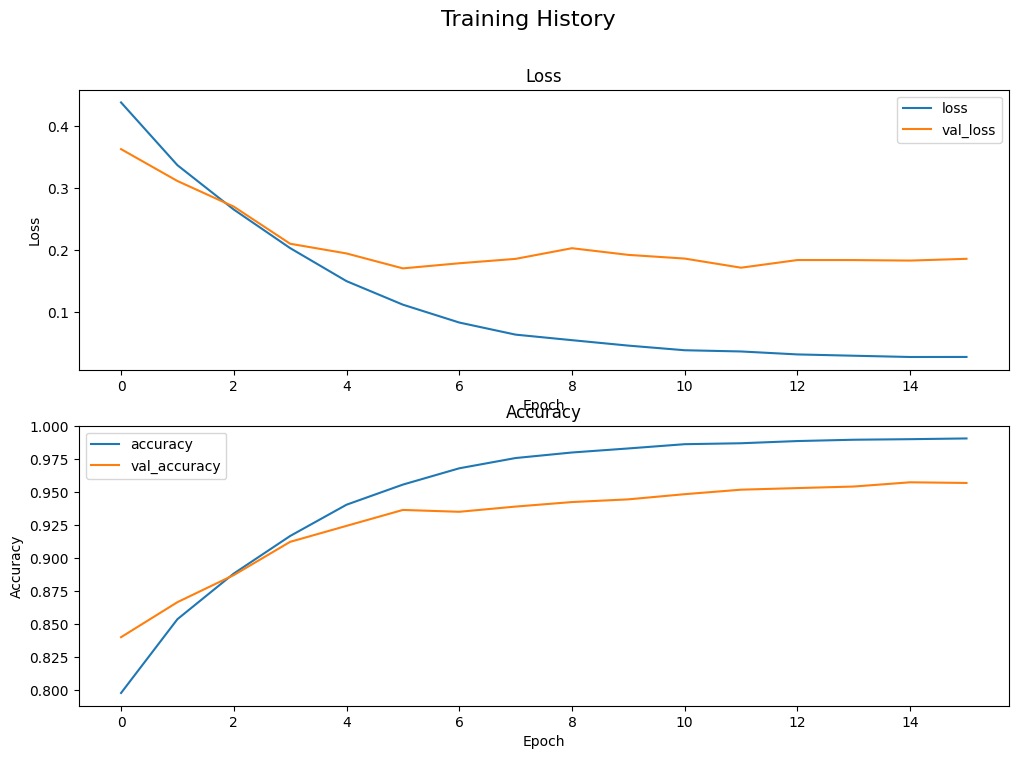

In [13]:
TEST_SIZE = 0.3
BATCH_SIZE = 10
EPOCHS = 100

# Encode Labels
encoded_labels = tf.one_hot(indices=labels, depth=2)
# Split dataset to train and test data
X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels.numpy(), test_size=TEST_SIZE)

# Train the model
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(x=X_train, y=y_train, validation_split=TEST_SIZE, epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stopping])

# Plot the training history
fig, axs = plt.subplots(2)
fig.set_size_inches(12, 8)
fig.suptitle('Training History', fontsize=16)
axs[0].plot(history.epoch, history.history['loss'], history.history['val_loss'])
axs[0].set(title='Loss', xlabel='Epoch', ylabel='Loss')
axs[0].legend(['loss', 'val_loss'])
axs[1].plot(history.epoch, history.history['accuracy'], history.history['val_accuracy'])
axs[1].set(title='Accuracy', xlabel='Epoch', ylabel='Accuracy')
axs[1].legend(['accuracy', 'val_accuracy'])
plt.show()

2245/2245 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


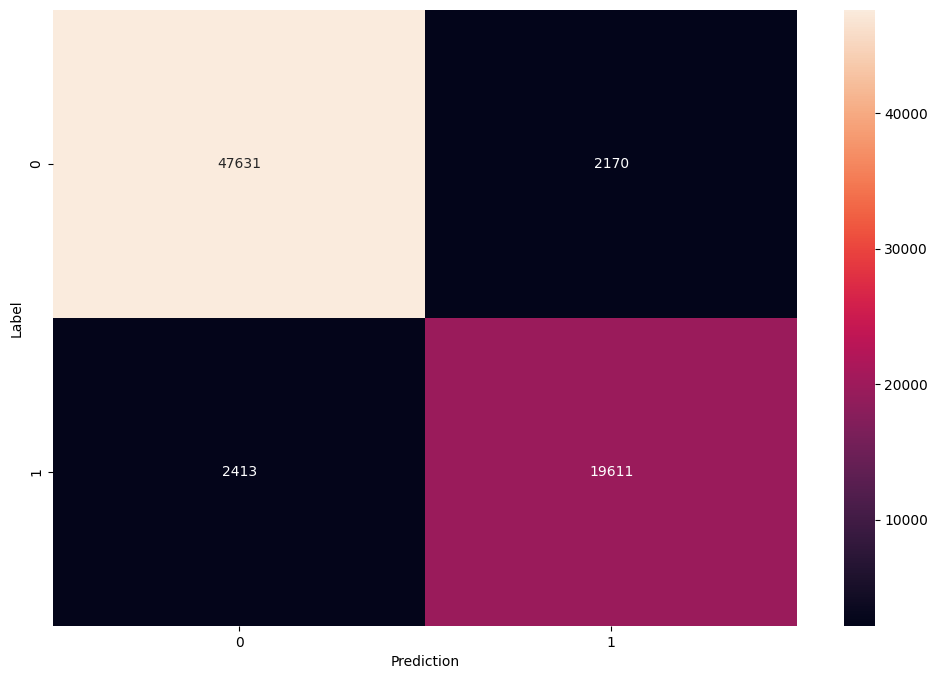

2245/2245 - 28s - 12ms/step - accuracy: 0.9362 - loss: 0.1749
Restored model, accuracy: 93.62%


In [14]:
y_predicted = np.argmax(model.predict(x=X_test), axis=1)
y_true = np.argmax(y_test, axis=1)
label_names = np.unique(labels)
confusion_matrix = tf.math.confusion_matrix(labels=y_true, predictions=y_predicted)
fig = plt.figure()
fig.set_size_inches(12, 8)
sns.heatmap(confusion_matrix, xticklabels=label_names, yticklabels=label_names, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()
loss, acc = model.evaluate( X_test, y_test, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

In [15]:
print(sklearn.metrics.classification_report(y_true, y_predicted))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     49801
           1       0.90      0.89      0.90     22024

    accuracy                           0.94     71825
   macro avg       0.93      0.92      0.92     71825
weighted avg       0.94      0.94      0.94     71825



In [16]:
model.save(f'{window}/24-{block_duration}({BATCH_SIZE})-512.keras')